### Loading useful packages

In [1]:
import os, glob, gc
import itertools
import progressbar
import numpy as np
import pandas as pd
import hvplot.pandas
import seaborn as sns
import pyLPD.MLtools as mlt

from matplotlib import rcParams
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
from sympy import symbols, sqrt, diff, lambdify
from scipy import constants, interpolate, signal, optimize

π = constants.pi
c = constants.c

%run '/home/marvyn/GDrive/marvyn.inga@gmail.com/LPD_IFGW_UNICAMP/Python Scripts/cprint.py'

### Customizing plots
We used **rcParams** to set figures format.

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = '12'
rcParams['font.style'] = 'normal'
rcParams['font.weight'] = 'medium'
rcParams['pdf.fonttype'] = '42'

rcParams['grid.linestyle'] = ':'
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha'] = 0.5

rcParams['lines.linewidth'] = 1

rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0
rcParams['axes.axisbelow'] = True

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

rcParams["figure.frameon"] = False

rcParams['text.usetex'] = False

# rcParams["figure.figsize"] = [6.4, 4.8]
# rcParams['figure.autolayout'] = True

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

<br/><br/><br/><br/>

---
# 2. Dispersion Data Analysis
---

### Listing processing data
- **Glob** allow to list all files named like **...-Processed.parq**

In [3]:
path = '/home/marvyn/GDrive/m144595@dac.unicamp.br/LPD Team/Experiments/Microspheres/2018-12-17_Sphere_Al2O3-120nm_Broad-and-QFactor/Broad/'
flist = sorted(glob.glob(path + '*Processed*.parq'), key = os.path.getmtime)
flist

['/home/marvyn/GDrive/m144595@dac.unicamp.br/LPD Team/Experiments/Microspheres/2018-12-17_Sphere_Al2O3-120nm_Broad-and-QFactor/Broad/Sphere_Al2O3-120nm_Tunics-LPD-Laser-Broadband-20nms-1_Time_17-12-2018_16-22-22-Processed.parq']

### Choosing one processed data files

In [4]:
N = 0
fname = flist[N]
print('The the name of the chosen file is: \n' + cprint.CSELECTED + fname + cprint.CEND)

data = pd.read_parquet(fname)
print('Dataframe memory usage: \n' + cprint.CSELECTED + f'{round(data.shape[1]*data.memory_usage(index=False).mean()/1e6,2)} MB' + cprint.CEND)
data.head()

The the name of the chosen file is: 
/home/marvyn/GDrive/m144595@dac.unicamp.br/LPD Team/Experiments/Microspheres/2018-12-17_Sphere_Al2O3-120nm_Broad-and-QFactor/Broad/Sphere_Al2O3-120nm_Tunics-LPD-Laser-Broadband-20nms-1_Time_17-12-2018_16-22-22-Processed.parq
Dataframe memory usage: 
377.75 MB


,freq,mzi,cav
0,186.422025,0.986011,0.979742
1,186.422026,0.984959,0.977231
2,186.422027,0.981424,0.984604
3,186.422028,0.976940,0.990265
4,186.422029,0.971377,0.981168


### Cavity lower envelope to find a representative FSR using FFT
- Is possible to find a representative value of the FSR using the FFT of the cavity lower envelope.
- Uncomment the *hvplot* line code only to set parameters of the *envPeaks* function.

In [5]:
data['ylower_cav'], yupper = mlt.envPeak(data.cav.values, delta=0.08, smooth=0.002, sg_order=1)

# data.hvplot(y=['cav', 'ylower_cav'], width=1200, height=200, hover=False, datashade=True)

iterator L,R(mintab)= (6, 7)


### Downsampling data in order to use interactive plots of matplotlib
- Interpolate using a downsamplig data.
- Generate new vectors with points limited by the extremes used in the interpolation.

In [6]:
freq_res = 20e6 # in Hz
npt_freq = int(np.abs(data.freq.iloc[0]-data.freq.iloc[-1])/(freq_res*1e-12))
print('Number of points used for dowsampling: ' + cprint.CSELECTED + f'{npt_freq}' + cprint.CEND)

f_linear_vec = np.linspace(data.freq.iloc[0], data.freq.iloc[-1], npt_freq)
mzi_ifunc = interpolate.interp1d(data.freq, data.mzi)
cav_ifunc = interpolate.interp1d(data.freq, data.cav)
env_ifunc = interpolate.interp1d(data.freq, data.ylower_cav)

mzi_ivec = mzi_ifunc(f_linear_vec)
cav_ivec = cav_ifunc(f_linear_vec)
env_ivec = env_ifunc(f_linear_vec)

Number of points used for dowsampling: 946836


### Filtering lower-envelope of cavity transmission
- [filtfilt](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.filtfilt.html) function applies a linear filter twice, once forward and once backwards
- A relatively sinusoidal output in order to identify the FSR was gotten.

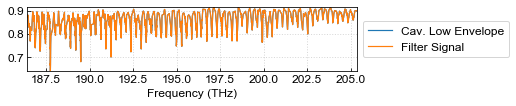

In [7]:
b, a = signal.butter(N=2, Wn=0.05)
y_filt = signal.filtfilt(b, a, env_ivec)

plt.figure(figsize=cm2inch(15,3))
plt.plot(f_linear_vec, env_ivec, lw=1.2, label='Cav. Low Envelope')
plt.plot(f_linear_vec, y_filt, lw=1.2, label='Filter Signal')
plt.xlabel('Frequency (THz)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig(fname[:-5]+'_Cav-Low_Envelope.svg')
plt.grid(True)

plt.show()

### Calculating FFT
- Find FFT peaks and plotting
- The FSR of our cavities are expected to have an FSR between 200 GHz - 400 GHz

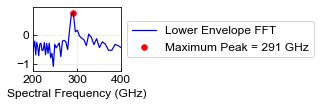

Possible FSR values are:
291 GHz


In [8]:
delta_i = 2000
yvec1, yvec2 = y_filt, cav_ivec
Y1, Y2 = np.fft.fft(yvec1[0:int(len(yvec1)):delta_i]), np.fft.fft(yvec2[0:int(len(yvec2)):delta_i])
d_sample = (f_linear_vec[delta_i]-f_linear_vec[0])
freq = np.fft.fftfreq(len(Y1), d=d_sample)

spec_freq = 1e3/freq[1:int(len(freq)/2)] # x-axis: spectral frequency GHz
y1log = np.log10(np.abs(Y1[1:int(len(freq)/2)]))
y2log = np.log10(np.abs(Y2[1:int(len(freq)/2)]))

ind_maxfft, maxtabfft, ind_minfft, mintabfft = mlt.peakdet(y1log, 1) 
sorted_peaks = spec_freq[ind_maxfft[np.argsort(maxtabfft)[::-1]]]

fsr_min, fsr_max = 200, 400 # in GHz
plt.figure(figsize=cm2inch(4,3))
plt.plot(spec_freq, y1log, color='mediumblue', lw=1.2, label='Lower Envelope FFT')
plt.scatter(spec_freq[ind_maxfft], maxtabfft, c='r', s=30, zorder=2, label=f'Maximum Peak = {int(sorted_peaks[0])} GHz')
plt.xlim(fsr_min, fsr_max)
plt.ylim(min(y1log)+0.2, max(y1log)+0.2)
plt.xlabel('Spectral Frequency (GHz)')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig(fname[:-5]+'_FFT.svg')
plt.show()

FSRs = []
for ii in sorted_peaks:
    if fsr_min <= ii <= fsr_max:
        FSRs.append(ii)
        print(f'Possible FSR values are:' + cprint.CSELECTED +  f'\n{int(ii)} GHz' + cprint.CEND)

### Associating a range of peaks with a given "m" number
- Generate delta-function peaks centered at every half FSR: *ytrigger*
- Find the position of the peaks *peakdet*
- Pick only one peak per FSR, ignoring negative peaks
- Adjust the offset in the interactive plot in order to have a given mode family within one fsr

In [9]:
radial_order = int(input('Input the radial order: '))

Input the radial order: 1


<IPython.core.display.Javascript object>


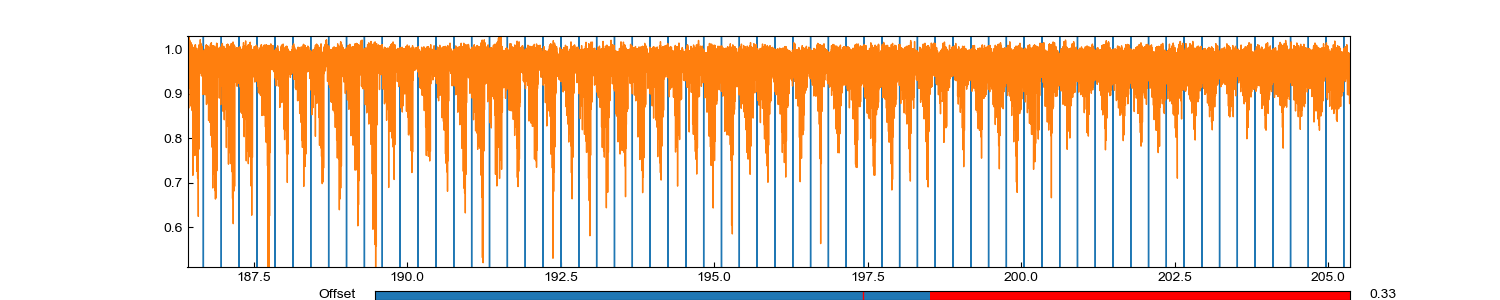

In [10]:
%matplotlib notebook

δ_rad1 = -0.14 # ORT: -0.22, Radial 1 - In MHz (Approximately equal to D2/2π for radial 1 of the cavity)
δ_rad2 = 0 # ORT: 0.20, Radial 2 - In MHz (Approximately equal to D2/2π for radial 2 of the cavity)

if radial_order==1: δ = δ_rad1
else: δ = δ_rad2

fsr_0 = 1e-3*FSRs[0] # in THz
fsr = fsr_0 + 1e-3*(δ/2/π/fsr_0)*(f_linear_vec-f_linear_vec[0]) # Cavity FSR in THz

ϕ0, ϕ = 2*π/fsr*f_linear_vec[0], 2*π/fsr*f_linear_vec
ytrigger = np.diff(np.sign(np.cos(ϕ-ϕ0)))

ind_max3, maxtab3, ind_min3, mintab3 = mlt.peakdet(ytrigger, delta=2)
ind_max3, maxtab3 = ind_max3[maxtab3>1], maxtab3[maxtab3>1]

plt.figure(figsize=(15,3))
l, = plt.plot(f_linear_vec[0:-1], ytrigger)
plt.plot(data.freq, data.cav)
plt.ylim(min(cav_ivec), max(cav_ivec))

axcolor = 'red'
ax_shift = plt.axes([0.25, 0, 0.65, 0.03], facecolor=axcolor)
s_shift = Slider(ax_shift, 'Offset', 0, 2*np.mean(fsr), valinit=np.mean(fsr))

def update(val):
    shift = s_shift.val
    l.set_ydata(np.diff(np.sign(np.cos(ϕ-ϕ0-2*π/fsr*shift))))
    fig.canvas.draw_idle()

s_shift.on_changed(update)
plt.show()

### Coloring mode groups go check mu_vec association

In [14]:
%matplotlib inline
%recall 2

In [15]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = '12'
rcParams['font.style'] = 'normal'
rcParams['font.weight'] = 'medium'
rcParams['pdf.fonttype'] = '42'

rcParams['grid.linestyle'] = ':'
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha'] = 0.5

rcParams['lines.linewidth'] = 1

rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0
rcParams['axes.axisbelow'] = True

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

rcParams["figure.frameon"] = False

rcParams['text.usetex'] = False

# rcParams["figure.figsize"] = [6.4, 4.8]
# rcParams['figure.autolayout'] = True

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

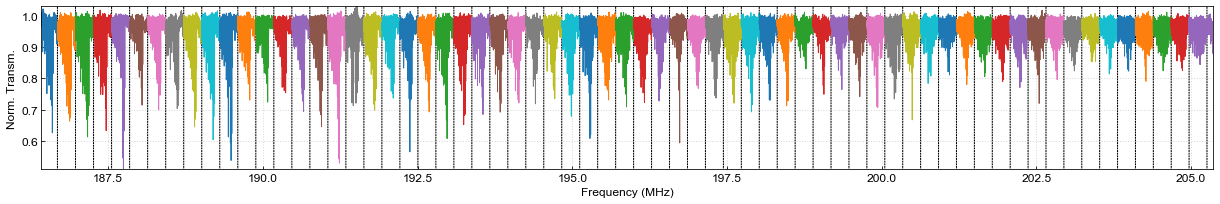

In [16]:
ytrigger = np.diff(np.sign(np.cos(ϕ-ϕ0-2*π/fsr*s_shift.val)))

ind_max3, maxtab3, ind_min3, mintab3 = mlt.peakdet(ytrigger, delta=2)
ind_max3, maxtab3 = ind_max3[maxtab3>1], maxtab3[maxtab3>1]

ind_mu = ind_max3

if np.any(ind_mu<0): ind_mu[ind_mu<0]=0
else: ind_mu = np.insert(ind_mu, 0, 0, axis=0)

if (not np.any(ind_mu==(len(f_linear_vec)-1))):
    ind_mu = np.insert(ind_mu, len(ind_mu), len(f_linear_vec)-1, axis=0)

plt.figure(figsize=(21, 3))
plt.plot(f_linear_vec[0:-1], ytrigger, 'k:')
for kk in range(0, len(ind_mu)-1):
    plt.plot(f_linear_vec[ind_mu[kk]:ind_mu[kk+1]], cav_ivec[ind_mu[kk]:ind_mu[kk+1]])

plt.ylim(min(cav_ivec), max(cav_ivec))
plt.grid(True)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Norm. Transm.')
plt.tight_layout
plt.show()

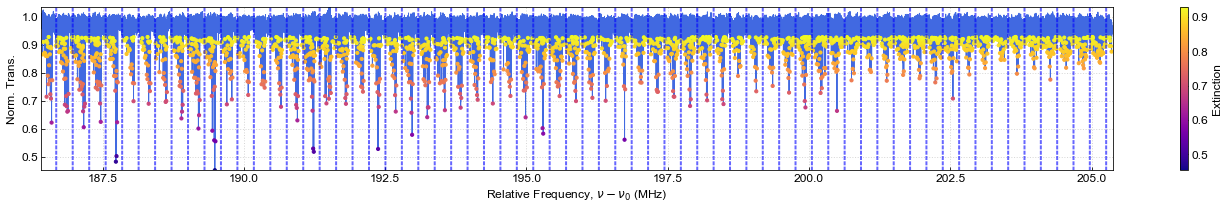

5142

In [22]:
ind_max, maxtab, ind_min, mintab = mlt.peakdet(data.cav.values, 0.05)

max_threshold_rad1 = 0.93
max_threshold_rad2 = 0.93

if radial_order==1: max_threshold = max_threshold_rad1
else: max_threshold = max_threshold_rad2

mask = mintab < max_threshold
ind_min, mintab = ind_min[mask], mintab[mask]

fig = plt.figure(figsize=(24,3))
plt.plot(f_linear_vec[0:-1][ytrigger>-0.5], ytrigger[ytrigger>-0.5], 'b:', lw=2, alpha=0.6)
plt.plot(data.freq, data.cav, label='Cavity', c='royalblue', lw=1, zorder=1)

sc0 = plt.scatter(data.freq[ind_min], mintab, c=mintab, s=10, vmin=np.min(mintab), vmax=np.max(mintab), cmap='plasma', zorder=2)
plt.colorbar(sc0, label='Extinction')

plt.xlabel(r'Relative Frequency, $\nu-\nu_0$ (MHz)')
plt.ylabel('Norm. Trans.')
plt.ylim(data.cav.min(), data.cav.max())
plt.grid(True)

plt.show()
fig.clear()
plt.close(fig)
gc.collect()

### Defining useful functions to fit lorentzian curves like ressonances

In [23]:
def cav_lorentzian(Delta, delta0, eta, kappa):
    den = 4*(Delta-delta0)**(2)+kappa**(2)
    num = 4*(Delta-delta0)**(2)+(1-2*eta)**(2)*kappa**(2)
    func =  num/den
    return func


def Q_factor(peak_index, plot=False):
    
    ind_0 = ind_min[peak_index]
    delta_ind = 10*np.where(data.cav[ind_0:]>(data.cav[ind_0]+(np.max(data.cav)-data.cav[ind_0])/2))[0][0]
    ind_i = ind_0 - int(delta_ind)
    ind_f = ind_0 + int(delta_ind)
    
    freq_res = 1e6*(data.freq[int(ind_i):int(ind_f)] - data.freq[ind_0]) # in MHz
    mzi_res = data.mzi[int(ind_i):int(ind_f)]
    cav_res = data.cav[int(ind_i):int(ind_f)]

    nstd = 0.5 # numero de desvios-padrão para se ignorar
    background_mask = cav_res>(np.max(cav_res)-nstd*np.std(cav_res)) # remove the ressonance peak 
    
    background = np.mean(cav_res[background_mask])
    cav_norm = cav_res/background
    
    guess = [0, 0.1, 10]
    pfit, pcov = optimize.curve_fit(cav_lorentzian, freq_res, cav_norm, p0=guess, maxfev=1500)
    
    eta = pfit[1]
    kappa = pfit[2]
    kappa_i = kappa*(1-eta)
    kappa_e = kappa*eta
    freq_peak = data.freq[ind_min[peak_index]] # in THz
    Q_t = freq_peak/kappa

    if plot==True:
        
        legenda = 'Lorenztian fit:\n' + \
        r' $\eta$ = {:2.2g};'.format(eta) + '\n' \
        r' $\kappa_i/2\pi$ = {:.1f} MHz'.format(kappa_i) + '\n' +\
        r' $\kappa_e/2\pi$ = {:.1f} MHz'.format(kappa_e) + '\n' +\
        r' $\nu_0$ = {:.2f} THz'.format(freq_peak) + '\n' +\
        r' $Q_t$ = {:.1f} M'.format(Q_t)

        fig, [ax1, ax2] = plt.subplots(2, 1, figsize=cm2inch(5,6.5), sharex=True)
        ax1.scatter(freq_res, cav_norm, color='mediumblue', marker='o', s=30, label='data', alpha=0.7)
        ax1.plot(freq_res, cav_lorentzian(freq_res, *pfit), color='brown', label=legenda, lw=1.5)
        ax1.grid(True)
        fig.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))

        ax2.scatter(freq_res, mzi_res, color='mediumblue', marker='o', s=30, alpha=0.7)
        ax2.set_yticks(np.arange(0,1.01,.5))

        plt.xlabel(r'Detuning, $\Delta/2\pi$ (MHz)')
#         plt.ylabel('Norm. Trans.')
        ax2.grid(True)
        
        plt.tight_layout()
#         plt.savefig(fname[:-5]+'Frequency_'+'{:.2f}THz'.format(freq_peak)+'_Quality-Factor_'+'{:.0f}M'.format(Q_t)+'.svg', bbox_inches='tight') 
        plt.show()
        
    return freq_peak, Q_t

### Finding loaded quality factors

In [24]:
Q_vec = np.zeros(len(ind_min))
ν_vec = np.zeros(len(ind_min))

for index in progressbar.progressbar(range(len(ind_min))):
    freq_peak, Q_t = Q_factor(peak_index=index, plot=False)
    ν_vec[index] = freq_peak  # in THz
    Q_vec[index] = Q_t # in millions

100% (2007 of 2007) |####################| Elapsed Time: 0:06:50 Time:  0:06:50


### Optical mode identification using the quality factor criteria
- Define frequency limits ($\nu_i$ and $\nu_f$) according to the best situation.
- Define a new vector *Q_range* considering the interval defined above.


In [ ]:
# %matplotlib notebook
# %matplotlib inline

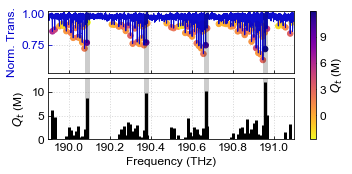

1437

In [25]:
νi, νf = 189.9, 191.1
νi_idx = np.where(data.freq[ind_min]>=νi)[0][0]
νf_idx = np.where(data.freq[ind_min]<=νf)[0][-1]
Q_range = Q_vec[νi_idx:νf_idx]
idx_range = np.arange(data.index[νi<=data.freq][0], data.index[data.freq<=νf][-1])
Q_th = 8

fig, axs = plt.subplots(2, 1, figsize=cm2inch(14,6), sharex=True)
fig.subplots_adjust(hspace=0.08)

axs[0].plot(data.freq[idx_range], data.cav[idx_range], c='mediumblue', alpha=0.95)
pcm = axs[0].scatter(data.freq[ind_min[νi_idx:νf_idx]], mintab[νi_idx:νf_idx], c=Q_range, s=30, vmin=np.min(Q_range), vmax=np.max(Q_range), cmap='plasma_r')
for ii in range(len(ν_vec[νi_idx:νf_idx])):
    if Q_range[ii]>=Q_th: axs[0].axvline(ν_vec[νi_idx:νf_idx][ii], color='k', lw=5, alpha=0.2)
axs[0].set_ylabel('Norm. Trans.', color='mediumblue')
axs[0].tick_params('y', colors='mediumblue')
axs[0].set_ylim(min(mintab[νi_idx:νf_idx])-0.1, max(maxtab[νi_idx:νf_idx]))
axs[0].grid(True)

axs[1].vlines(ν_vec[νi_idx:νf_idx], 0, Q_range, lw=3)
for ii in range(len(ν_vec[νi_idx:νf_idx])):
    if Q_range[ii]>=Q_th: axs[1].axvline(ν_vec[νi_idx:νf_idx][ii], color='k', lw=5, alpha=0.2)
axs[1].set_ylabel(r'$Q_t$ (M)', color='k')
axs[1].set_xlabel('Frequency (THz)')
axs[1].tick_params('y', colors='k')
axs[1].set_yticks(np.arange(0, np.max(Q_range), np.round(np.max(Q_range)/2.5)))
axs[1].set_ylim(0, np.max(Q_range)+1)
axs[1].grid(True)

axb = fig.colorbar(pcm, ax=axs[:], shrink=1, ticks=np.arange(0,round(max(Q_range)),round(max(Q_range)/4)), label=r'$Q_t$ (M)')

# plt.savefig(fname[:-5]+'_Optical-Mode-Indentification.svg')
plt.show()
fig.clear()
plt.close(fig)
gc.collect()

### Characterizing an specific ressonance

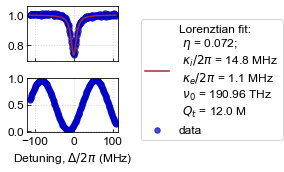

(190.95867627115575, 11.986432611312681)

In [26]:
idx_fit = np.where(ind_min==ind_min[νi_idx:νf_idx][Q_range.argmax()])[0][0]
Q_factor(idx_fit, plot=True)

### Verifying
- In the preprocessing script we defined $\lambda_0$= 1534.972 as the Peak-11 of the HCN R-Branch.


In [27]:
freq_interval = f_linear_vec[ind_mu]
mu_vec = np.zeros(len(ind_min))

for i in range(0, len(freq_interval)-1):
    mask_fsr = (freq_interval[i+1]>=data.freq[ind_min])&(data.freq[ind_min]>=freq_interval[i])
    mu_vec[mask_fsr.values] = i

λ0 = 1534.972 # in nm
freq0 = 1e-3*c/λ0 # in THz

idx_center = (data.freq[ind_min]-freq0).abs().idxmin()
f0 = data.freq[idx_center]
m0 = np.argmin(np.abs(f0-f_linear_vec[ind_mu]))

print('m0 = {}'.format(m0))
print('f0 = {:.2f} THz'.format(f0))
print('f0 should be into the interval [{:.1f}, {:.1f}]'.format(freq_interval[m0-1], freq_interval[m0]))

m0 = 31
f0 = 195.31 THz
f0 should be into the interval [195.1, 195.4]


### Choosing the best fit to dispersion
- Crop fitting region
- Fitting a line to the data
- Evaluating fitting function


<IPython.core.display.Javascript object>


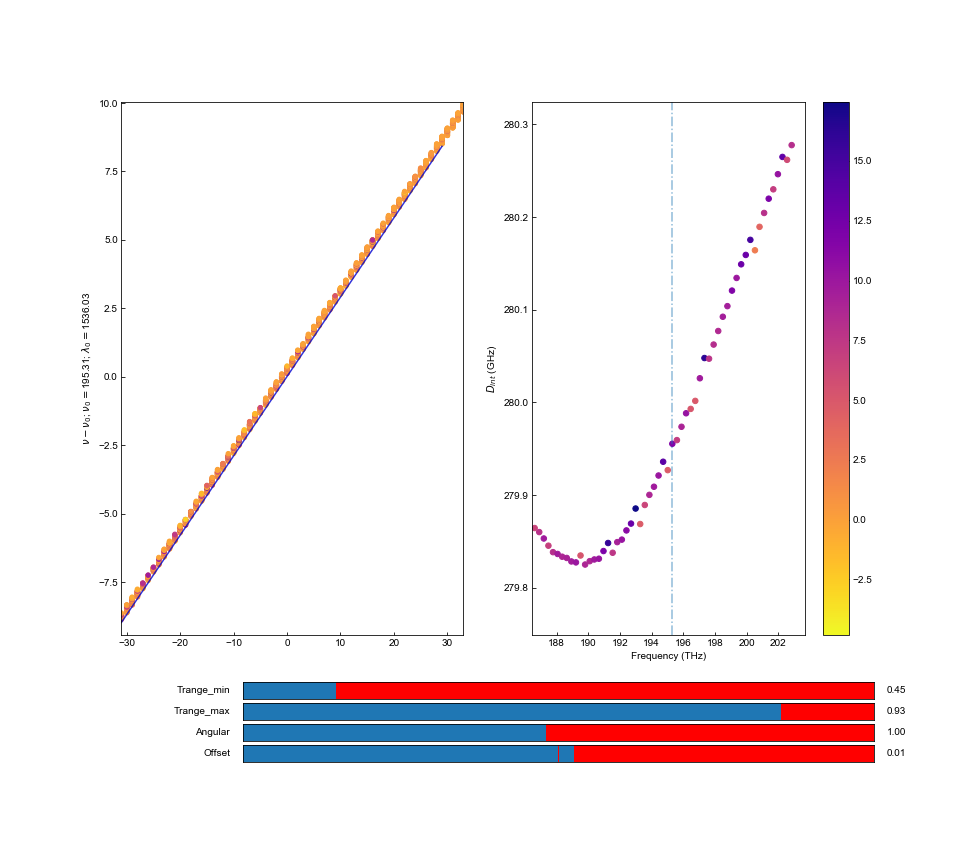

In [34]:
%matplotlib notebook

fmax = 300 # in GHz
m_shift = mu_vec - m0
f_vec =  data.freq[ind_min].values[0:len(m_shift)]
f_shift = f_vec - f0

m_start, m_end = 0, 2*m0-1
i_start = np.argmin(np.abs(mu_vec-m_start))
i_end = np.argmin(np.abs(mu_vec-m_end))

funcfit1 = lambda x, p: p*x 
pfit1, pcov1 = optimize.curve_fit(funcfit1, m_shift[i_start:i_end], f_shift[i_start:i_end], [1])
f_fit2 = funcfit1(m_shift, pfit1*1.05)

fig, ax = plt.subplots(2,1,figsize=(12,8))
plt.subplots_adjust(bottom=0.25)
cm = plt.cm.get_cmap('plasma_r')

#--------------------
# Frequency vs μ plot
#--------------------
plt.subplot(121)
plt.scatter(m_shift, f_shift, c=Q_vec, s=20, vmin=np.min(Q_vec), vmax=np.max(Q_vec), cmap=cm) # Experimental peak pos.
l, = plt.plot(m_shift[i_start:i_end], f_fit2[i_start:i_end], color='mediumblue', ls='-', lw=1.5, alpha=0.8)
plt.ylabel(r'$\nu-\nu_0$; $\nu_0=${:3.2f}; $\lambda_0=${:3.2f}'.format(f0,3e5/f0))

plt.subplot(122)
sc = plt.scatter(f_vec, 1e3*(f_shift-f_fit2), c=Q_vec, s=30, vmin=np.min(Q_vec), vmax=np.max(Q_vec), cmap=cm)
plt.axvline(x=f0, ls='-.', lw=1.5, alpha=0.5)
plt.colorbar(sc)
ax_disp = plt.gca()

plt.ylabel(r'$D_{int}$ (GHz)')
plt.xlabel('Frequency (THz)')
#------
#control axes
axcolor = 'red'
ax_shift = plt.axes([0.25, 0.1, 0.65, 0.02], facecolor=axcolor) # vertical offset
ax_angular = plt.axes([0.25, 0.125, 0.65, 0.02], facecolor=axcolor) # angular coeff.
ax_transMax = plt.axes([0.25, 0.15, 0.65, 0.02], facecolor=axcolor) # angular coeff.
ax_transMin = plt.axes([0.25, 0.175, 0.65, 0.02], facecolor=axcolor) # angular coeff.
#-------
#SLIDER
s_shift = Slider(ax_shift, 'Offset', -0.2, 0.2, valinit=0, valstep=0.01)
s_angular= Slider(ax_angular, 'Angular', 0.98, 1.02, valinit=1.0, valstep=5e-7)
s_transMax = Slider(ax_transMax, 'Trange_max', np.min(mintab)-0.1, np.max(mintab)+0.1, valinit=np.max(mintab))
s_transMin = Slider(ax_transMin, 'Trange_min', np.min(mintab)-0.1, np.max(mintab)+0.1, valinit=np.min(mintab))

#------
def update(val):
    shift = s_shift.val
    angular = s_angular.val
    #---
    tmax = s_transMax.val
    tmin = s_transMin.val
    mask = mintab>0
    y_curve = funcfit1(m_shift, (angular*pfit1))+shift
    l.set_ydata(y_curve[i_start:i_end])
    yplot = 1e3*(f_shift-y_curve)
    sc.set_offsets(np.c_[f_vec[mask], yplot[mask]])
    fig.canvas.draw_idle()

s_shift.on_changed(update)
s_angular.on_changed(update)
s_transMax.on_changed(update)
s_transMin.on_changed(update)
#---
plt.show()

In [35]:
%matplotlib inline

disp_yrange=np.array(ax_disp.get_ylim())
disp_xrange=np.array(ax_disp.get_xlim())

m_range = [np.argmin(np.abs(f_vec-disp_xrange[0])),np.argmin(np.abs(f_vec-disp_xrange[1]))]
disp_xrange = [m_shift[m_range[0]],(m_shift[m_range[1]-1])]

y_curve = funcfit1(m_shift,(s_angular.val*pfit1))+s_shift.val
ydisp = 1e3*(f_shift-y_curve) # freq_shift in GHz
mask_y = (ydisp>disp_yrange[0])&(ydisp<disp_yrange[1])
mask_x = (m_shift>disp_xrange[0])&(m_shift<disp_xrange[1])

mask = mask_x&mask_y
disp_masked = f_shift[mask]
m_masked = m_shift[mask]
Q_masked = Q_vec[mask]

dispfit = lambda x, *p: p[0] + p[1]*x + p[2]/2*x**2 + p[3]/6*x**3 + p[4]/24*x**4
pfit_disp, pcov_disp = optimize.curve_fit(dispfit, m_masked, disp_masked, [1,0,0,0,0])

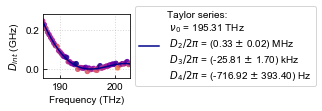

In [37]:
legenda = 'Taylor series:\n' + \
        r' $\nu_0$ = {:.2f} THz'.format(f0) + '\n' \
        r' $D_2/2\pi$ = ({:.2f} $\pm$ {:.2f}) MHz'.format(1e6*pfit_disp[2], 1e6*np.sqrt(pcov_disp[2,2])) + '\n' \
        r' $D_3/2\pi$ = ({:.2f} $\pm$ {:.2f}) kHz'.format(1e9*pfit_disp[3], 1e9*np.sqrt(pcov_disp[3,3])) + '\n' +\
        r' $D_4/2\pi$ = ({:.2f} $\pm$ {:.2f}) Hz'.format(1e12*pfit_disp[4], 1e12*np.sqrt(pcov_disp[4,4]))


plt.figure(figsize=cm2inch(4,3))

sc = plt.scatter(disp_masked+f0, 1e3*(disp_masked-dispfit(m_masked,*[pfit_disp[0], pfit_disp[1], 0, 0, 0])), c=Q_masked, s=20, 
                 vmin=np.min(Q_vec), vmax=np.max(Q_vec), cmap='plasma_r', alpha=0.9)
# plt.colorbar(sc)

plt.plot(disp_masked+f0, 1e3*dispfit(m_masked, *[0, 0, pfit_disp[2], pfit_disp[3], pfit_disp[4]]), color='darkblue', lw=1.5, alpha=1, label=legenda, zorder=1)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
plt.xlabel('Frequency (THz)')
plt.ylabel(r'$D_{int}$ (GHz)')
plt.grid(True)

# if radial_order==1: plt.savefig(fname[0:-5]+'_1st-Family.svg', bbox_inches="tight")
# else: plt.savefig(fname[0:-5]+'_2nd-Family.svg', bbox_inches="tight")

plt.show()

In [38]:
df = pd.DataFrame()

df['μ'] = m_masked
df['Δν (THz)'] = disp_masked
df['ν (THz)'] = disp_masked+f0
df['Q-factor'] = Q_masked

In [39]:
df.hvplot.scatter(x='μ', y='Δν (THz)', size=30, alpha=0.8)

:Scatter   [μ]   (Δν (THz))

In [40]:
df.to_csv(fname[0:-5]+'_Data-Dispersion_1st-Family.csv', index=False)

In [ ]:
%reset -f